# Example to connect to postgres

This is a tutorial to connect to our PostgreSQL database using python.

First you need to install the following libraries:
- psycopg2
- python-dotenv

Then you need to create a file with the name ".env". This file will contain the connection information and your credentials. This is an example:

```
DB_HOST=host_name
DB_NAME=postgres
DB_USER=my_user
DB_PASSWORD=my_password
DB_PORT=5432
```

After that you´re all set. We will import your credentials and connect to the database.

In [42]:
import os
import psycopg2 # PostgreSQL database adapter for Python
from dotenv import load_dotenv # Reads the key-value pair from .env file and adds them to environment variable

# Load environment variables from .env file
load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [43]:
# Connect to the database
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

Now we can query our data (write sql code) and store it as a pandas dataframe

In [44]:
import pandas as pd
from sklearn.metrics import mean_squared_error

In [45]:
#query="""
#    select * 
#    from agg.t_msb1m  
#    where year = 2019 and site=84 and min = 0 and month = 6 ,month between 6 and 10
#"""

In [46]:
query="""
    select * 
    from agg.tidy_data_final  
    where year = 2020 and site = 20 and month between 2 and 3
"""

In [47]:
df = pd.read_sql_query(query, conn)

C:\Users\xlow6\AppData\Local\Temp\ipykernel_13512\1553155693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [48]:
df.info()
df.head(-30)
# month and season if long term
# sunshine direction 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2780 entries, 0 to 2779
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   timestamp                  2780 non-null   datetime64[ns, UTC]
 1   site                       2780 non-null   int64              
 2   year                       2780 non-null   int64              
 3   month                      2780 non-null   int64              
 4   day                        2780 non-null   int64              
 5   hour                       2780 non-null   int64              
 6   minute                     2780 non-null   int64              
 7   day_of_week                2780 non-null   int64              
 8   season                     2780 non-null   int64              
 9   net_load                   2780 non-null   float64            
 10  precipitation              2780 non-null   float64            
 11  prec

,timestamp,site,year,month,day,hour,minute,day_of_week,season,net_load,...,precipitation_probability,wind_direction,wind_speed,solar_radiation,sunshine_duration,avg_net_load,q25_net_load,q75_net_load,median_net_load,weekend_or_bank_holiday
0,2020-02-12 07:00:00+00:00,20,2020,2,12,8,0,2,1,-4.78,...,36.0,268.0,16.0,2.0,0.0,368.62,13.200000,341.76,28.75,0
1,2020-01-31 23:00:00+00:00,20,2020,2,1,0,0,5,1,285.43,...,51.0,229.0,13.0,0.0,0.0,495.70,53.020000,299.53,162.28,1
2,2020-01-31 23:30:00+00:00,20,2020,2,1,0,30,5,1,303.27,...,51.0,229.0,13.0,0.0,0.0,496.37,70.540000,309.13,148.33,1
3,2020-02-01 00:30:00+00:00,20,2020,2,1,1,30,5,1,268.95,...,54.0,232.0,14.0,0.0,0.0,396.46,53.919287,268.95,139.57,1
4,2020-02-01 00:00:00+00:00,20,2020,2,1,1,0,5,1,402.69,...,54.0,232.0,14.0,0.0,0.0,452.94,55.300000,306.86,110.31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2745,2020-03-29 11:30:00+00:00,20,2020,3,29,12,30,6,2,-1242.79,...,2.0,48.0,18.0,248.0,56.0,-345.51,-734.210000,6.97,-14.44,1
2746,2020-03-29 12:00:00+00:00,20,2020,3,29,13,0,6,2,-1175.57,...,2.0,46.0,18.0,257.0,56.0,-408.28,-1060.010000,4.68,-90.92,1
2747,2020-03-29 12:30:00+00:00,20,2020,3,29,13,30,6,2,-1156.23,...,2.0,46.0,18.0,257.0,56.0,-374.37,-867.250000,11.89,-145.45,1
2748,2020-03-29 13:00:00+00:00,20,2020,3,29,14,0,6,2,-1071.73,...,3.0,43.0,18.0,245.0,56.0,-381.86,-838.650000,12.10,-431.34,1


In [49]:
# Average hourly
from sklearn.preprocessing import MinMaxScaler
df = df.drop('timestamp', axis=1)
#df = df.groupby(['year','month', 'day', 'hour']).sum().reset_index()
df['net_load_norm'] = df['net_load'] / max(abs(df['net_load']))


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2780 entries, 0 to 2779
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   site                       2780 non-null   int64  
 1   year                       2780 non-null   int64  
 2   month                      2780 non-null   int64  
 3   day                        2780 non-null   int64  
 4   hour                       2780 non-null   int64  
 5   minute                     2780 non-null   int64  
 6   day_of_week                2780 non-null   int64  
 7   season                     2780 non-null   int64  
 8   net_load                   2780 non-null   float64
 9   precipitation              2780 non-null   float64
 10  precipitation_probability  2780 non-null   float64
 11  wind_direction             2780 non-null   float64
 12  wind_speed                 2780 non-null   float64
 13  solar_radiation            2780 non-null   float

In [51]:
#df = df.rename(columns={'min': 'minute'})
df['datetime'] = pd.to_datetime(df[['year','month', 'day', 'hour']])
df = df.sort_values(by='datetime')

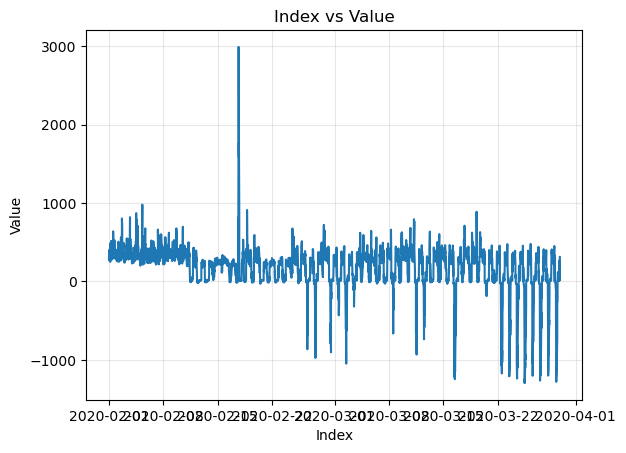

In [52]:
import matplotlib.pyplot as plt

plt.plot(df['datetime'],df['net_load'])
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Index vs Value')
plt.grid(alpha=0.3) 
plt.show()

(array([18293., 18300., 18307., 18314., 18322., 18329., 18336., 18343.]),
 [Text(18293.0, 0, '2020-02-01'),
  Text(18300.0, 0, '2020-02-08'),
  Text(18307.0, 0, '2020-02-15'),
  Text(18314.0, 0, '2020-02-22'),
  Text(18322.0, 0, '2020-03-01'),
  Text(18329.0, 0, '2020-03-08'),
  Text(18336.0, 0, '2020-03-15'),
  Text(18343.0, 0, '2020-03-22')])

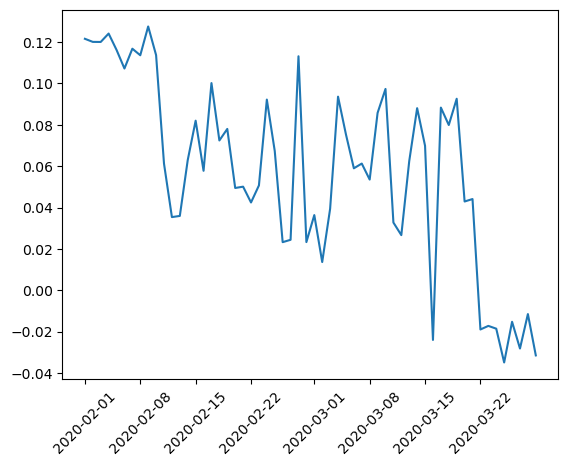

In [53]:
avg_load_day = df.groupby(df['datetime'].dt.date)['net_load_norm'].mean()
plt.plot(avg_load_day)
plt.xticks(rotation=45) 

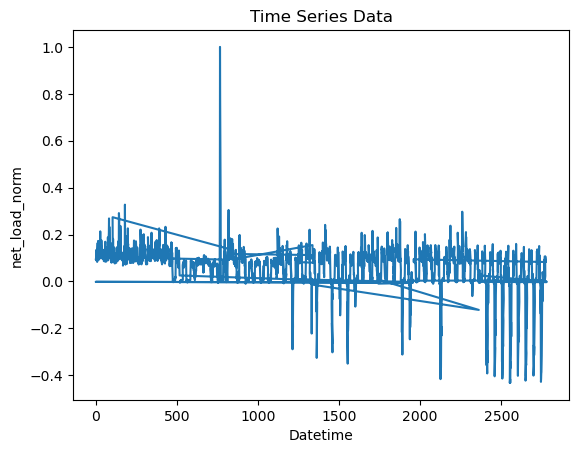

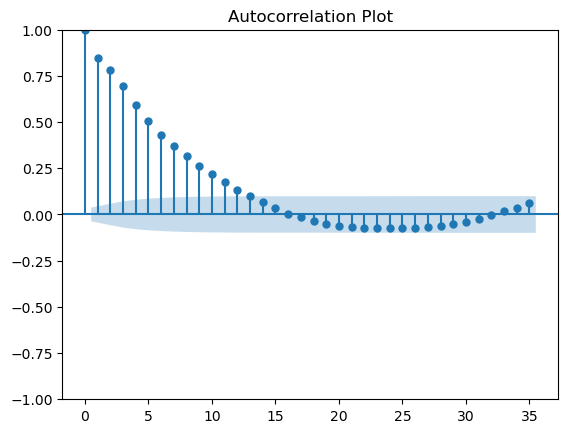

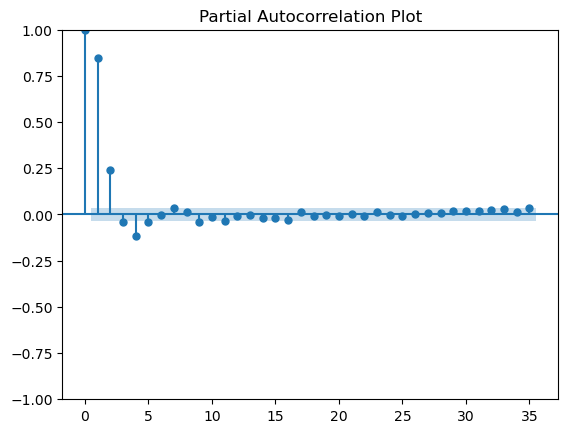

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df = df.sort_values(by='datetime')

# Plot the time series data
df['net_load_norm'].plot()
plt.xlabel('Datetime')
plt.ylabel('net_load_norm')
plt.title('Time Series Data')
plt.show()

# Plot autocorrelation and partial autocorrelation plots
plot_acf(df['net_load'])
plt.title('Autocorrelation Plot')
plt.show()

plot_pacf(df['net_load'])
plt.title('Partial Autocorrelation Plot')
plt.show()

In [55]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt
'''
df = df.sort_values(by='datetime')
results = pd.DataFrame()
for x in range(4,0,-1):
    vals = x*-24
    train_data = df.iloc[:vals]  
    test_data = df.iloc[vals:]
    test_data = test_data.iloc[:24]

    model = SARIMAX(train_data['net_load_norm'], exog=train_data[['solar_radiation','weekend_or_bank_holiday']], order=(4, 1, 3), seasonal_order=(2, 1, 1, 24))
    sarimax_model = model.fit()

    sarimax_params = sarimax_model.params

    print("SARIMAX Parameters:")
    print(sarimax_params)

    forecast_horizon = 24
    forecast = sarimax_model.forecast(steps=forecast_horizon, exog=test_data[['solar_radiation','weekend_or_bank_holiday']])
    #print('Forecasted Values:', forecast)
    df_final = pd.DataFrame()
    df_final = pd.concat([test_data, forecast], axis=1)
    print(df_final)

    results = pd.concat([results, df_final],ignore_index=True)

results = results.rename(columns={results.columns[-1]: 'forecast'})

plt.figure(figsize=(10, 6))
plt.plot(df['datetime'], df['net_load_norm'], label='Observed')
plt.plot(results['datetime'], results['forecast'], label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMAX Model Forecast')
plt.legend()
plt.xticks(rotation=45) 
plt.grid(alpha=0.3)
plt.show()
'''

'\ndf = df.sort_values(by=\'datetime\')\nresults = pd.DataFrame()\nfor x in range(4,0,-1):\n    vals = x*-24\n    train_data = df.iloc[:vals]  \n    test_data = df.iloc[vals:]\n    test_data = test_data.iloc[:24]\n\n    model = SARIMAX(train_data[\'net_load_norm\'], exog=train_data[[\'solar_radiation\',\'weekend_or_bank_holiday\']], order=(4, 1, 3), seasonal_order=(2, 1, 1, 24))\n    sarimax_model = model.fit()\n\n    sarimax_params = sarimax_model.params\n\n    print("SARIMAX Parameters:")\n    print(sarimax_params)\n\n    forecast_horizon = 24\n    forecast = sarimax_model.forecast(steps=forecast_horizon, exog=test_data[[\'solar_radiation\',\'weekend_or_bank_holiday\']])\n    #print(\'Forecasted Values:\', forecast)\n    df_final = pd.DataFrame()\n    df_final = pd.concat([test_data, forecast], axis=1)\n    print(df_final)\n\n    results = pd.concat([results, df_final],ignore_index=True)\n\nresults = results.rename(columns={results.columns[-1]: \'forecast\'})\n\nplt.figure(figsize=(1

In [56]:
'''
df2 = df[-300:]
plt.figure(figsize=(10, 6))
plt.plot(df2['datetime'], df2['net_load'], label='Observed')
plt.plot(results['datetime'], results['forecast'], label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMAX Model Forecast')
plt.legend()
plt.xticks(rotation=45) 
plt.grid(alpha=0.3)
plt.show()
'''

"\ndf2 = df[-300:]\nplt.figure(figsize=(10, 6))\nplt.plot(df2['datetime'], df2['net_load'], label='Observed')\nplt.plot(results['datetime'], results['forecast'], label='Forecast', color='red')\nplt.xlabel('Date')\nplt.ylabel('Value')\nplt.title('SARIMAX Model Forecast')\nplt.legend()\nplt.xticks(rotation=45) \nplt.grid(alpha=0.3)\nplt.show()\n"

In [57]:
import pmdarima as pm
'''
train_data = df.iloc[:-288]  

start_p = 2  # Starting value of AR parameter (p)
start_d = 1  # Starting value of differencing (d)
start_q = 0  # Starting value of MA parameter (q)
max_p = 2    # Maximum value of AR parameter (p)
max_d = 1    # Maximum value of differencing (d)must be 1
max_q = 0 

start_P = 2  # Starting value of seasonal AR parameter (P)
start_D = 1  # Starting value of seasonal differencing (D)
start_Q = 0  # Starting value of seasonal MA parameter (Q)
max_P = 2    # Maximum value of seasonal AR parameter (P)
max_D = 1    # Maximum value of seasonal differencing (D) must be 1
max_Q = 0    # Maximum value of seasonal MA parameter (Q)

model_auto = pm.auto_arima(train_data['net_load_norm'], exogenous=train_data[['solar_radiation','weekend_or_bank_holiday']], seasonal=True, m=48, start_p=start_p, start_d=start_d, start_q=start_q, max_p=max_p, max_d=max_d, max_q=max_q,start_P=start_P,start_D=start_D, start_Q=start_Q, max_P=max_P, max_D=max_D, max_Q=max_Q)
#sarimax_model = model.fit()
#model_auto = SARIMAX(train_data['net_load_norm'], exog=train_data[['solar_radiation','weekend_or_bank_holiday']], order=(1, 1, 1), seasonal_order=(0, 0, 0, 12))
'''


"\ntrain_data = df.iloc[:-288]  \n\nstart_p = 2  # Starting value of AR parameter (p)\nstart_d = 1  # Starting value of differencing (d)\nstart_q = 0  # Starting value of MA parameter (q)\nmax_p = 2    # Maximum value of AR parameter (p)\nmax_d = 1    # Maximum value of differencing (d)must be 1\nmax_q = 0 \n\nstart_P = 2  # Starting value of seasonal AR parameter (P)\nstart_D = 1  # Starting value of seasonal differencing (D)\nstart_Q = 0  # Starting value of seasonal MA parameter (Q)\nmax_P = 2    # Maximum value of seasonal AR parameter (P)\nmax_D = 1    # Maximum value of seasonal differencing (D) must be 1\nmax_Q = 0    # Maximum value of seasonal MA parameter (Q)\n\nmodel_auto = pm.auto_arima(train_data['net_load_norm'], exogenous=train_data[['solar_radiation','weekend_or_bank_holiday']], seasonal=True, m=48, start_p=start_p, start_d=start_d, start_q=start_q, max_p=max_p, max_d=max_d, max_q=max_q,start_P=start_P,start_D=start_D, start_Q=start_Q, max_P=max_P, max_D=max_D, max_Q=ma

In [58]:
import numpy as np
import pandas as pd
import pmdarima as pm
from tqdm import tqdm

# Assuming 'df' is your dataframe containing the data
train_data = df.iloc[:-480]

# Define ARIMA parameters ( need to trail q = 5)
start_p = 2  
start_d = 1  
start_q = 0  
max_p = 2  
max_d = 1  
max_q = 0  

start_P = 2  
start_D = 1  
start_Q = 0  
max_P = 2  
max_D = 1  
max_Q = 0  

# Determine the total iterations (a rough estimate)
total_iterations = (max_p - start_p + 1) * (max_d - start_d + 1) * (max_q - start_q + 1) * (max_P - start_P + 1) * (max_D - start_D + 1) * (max_Q - start_Q + 1)
print(total_iterations)

# Initialize tqdm progress bar
with tqdm(total=total_iterations) as pbar:
    def progress_callback(iteration):
        pbar.update(1)

    # Train ARIMA model with progress callback
    model_auto = pm.auto_arima(
        train_data['net_load_norm'],
        exogenous=train_data[['solar_radiation', 'weekend_or_bank_holiday','sunshine_duration', 'precipitation_probability']],
        seasonal=True,
        m=48,
        start_p=start_p,
        start_d=start_d,
        start_q=start_q,
        max_p=max_p,
        max_d=max_d,
        max_q=max_q,
        start_P=start_P,
        start_D=start_D,
        start_Q=start_Q,
        max_P=max_P,
        max_D=max_D,
        max_Q=max_Q,
        stepwise=True,
        callback=progress_callback
    )


1


  0%|          | 0/1 [00:00<?, ?it/s]

42it [03:07,  4.46s/it]                      


MemoryError: Unable to allocate 43.9 MiB for an array with shape (50, 50, 2301) and data type float64

In [ ]:
## 36 Hour forecast
results = pd.DataFrame()
for x in range(6,1,-1):
    vals = -x*48 +24 #to get midday
    train_data = df.iloc[:vals]  
    test_data = df.iloc[vals:]
    test_data = test_data.iloc[:72]

    model_auto.update(train_data['net_load_norm'], exog=train_data[['solar_radiation','weekend_or_bank_holiday','sunshine_duration', 'precipitation_probability']], maxiter=1)
    #model_auto.update(train_data['net_load_norm'])

    sarimax_params = model_auto.params

    #print("SARIMAX Parameters:")
    #print(sarimax_params)

    #forecast_horizon = 24
    #forecast = model.forecast(steps=forecast_horizon, exog=test_data[['solar_radiation','weekend_or_bank_holiday']])
    forecast, conf_int = model_auto.predict(n_periods=72, exogenous=test_data[['solar_radiation','weekend_or_bank_holiday','sunshine_duration', 'precipitation_probability']], return_conf_int=True)
    df_final = pd.DataFrame(test_data)
    df_final['forecast'] = forecast 
    print(df_final)
    df_final = df_final[24:]

    results = pd.concat([results, df_final],ignore_index=True)
    print(x-1)

results = results.rename(columns={results.columns[-1]: 'forecast'})

plt.figure(figsize=(10, 6))
plt.plot(df['datetime'], df['net_load_norm'], label='Observed')
plt.plot(results['datetime'], results['forecast'], label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMAX Model Forecast')
plt.legend()
plt.xticks(rotation=45) 
plt.grid(alpha=0.3)
plt.show()

      site  year  month  day  hour  minute  day_of_week  season  net_load  \
2099    20  2020      3   24    10      30            1       2  -1024.34   
2100    20  2020      3   24    10       0            1       2    -40.25   
2102    20  2020      3   24    11      30            1       2  -1184.72   
2101    20  2020      3   24    11       0            1       2  -1239.04   
2104    20  2020      3   24    12      30            1       2  -1104.16   
...    ...   ...    ...  ...   ...     ...          ...     ...       ...   
2166    20  2020      3   25    19      30            2       2     14.63   
2167    20  2020      3   25    20       0            2       2     32.13   
2168    20  2020      3   25    20      30            2       2     12.43   
2169    20  2020      3   25    21      30            2       2    392.29   
2170    20  2020      3   25    21       0            2       2     65.54   

      precipitation  ...  solar_radiation  sunshine_duration  avg_net_load 

MemoryError: Unable to allocate 552. MiB for an array with shape (99, 99, 7381) and data type float64

In [ ]:
'''
## Day Forecast
results = pd.DataFrame()
for x in range(4,0,-1):
    vals = -x*48
    train_data = df.iloc[:vals]  
    test_data = df.iloc[vals:]
    test_data = test_data.iloc[:48]

    model_auto.update(train_data['net_load_norm'], exog=train_data[['solar_radiation','weekend_or_bank_holiday','sunshine_duration', 'precipitation_probability']], maxiter=1)
    #model_auto.update(train_data['net_load_norm'])

    sarimax_params = model_auto.params

    print("SARIMAX Parameters:")
    print(sarimax_params)

    #forecast_horizon = 24
    #forecast = model.forecast(steps=forecast_horizon, exog=test_data[['solar_radiation','weekend_or_bank_holiday']])
    forecast, conf_int = model_auto.predict(n_periods=48, exogenous=test_data[['solar_radiation','weekend_or_bank_holiday','sunshine_duration', 'precipitation_probability']], return_conf_int=True)
    df_final = pd.DataFrame(test_data)
    df_final['forecast'] = forecast 

    results = pd.concat([results, df_final],ignore_index=True)
    print(x)

results = results.rename(columns={results.columns[-1]: 'forecast'})

plt.figure(figsize=(10, 6))
plt.plot(df['datetime'], df['net_load_norm'], label='Observed')
plt.plot(results['datetime'], results['forecast'], label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMAX Model Forecast')
plt.legend()
plt.xticks(rotation=45) 
plt.grid(alpha=0.3)
plt.show()
'''

SARIMAX Parameters:
<bound method ARIMA.params of ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(2, 0, 0, 48),
      suppress_warnings=True, with_intercept=False)>
4
SARIMAX Parameters:
<bound method ARIMA.params of ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(2, 0, 0, 48),
      suppress_warnings=True, with_intercept=False)>
3


KeyboardInterrupt: 

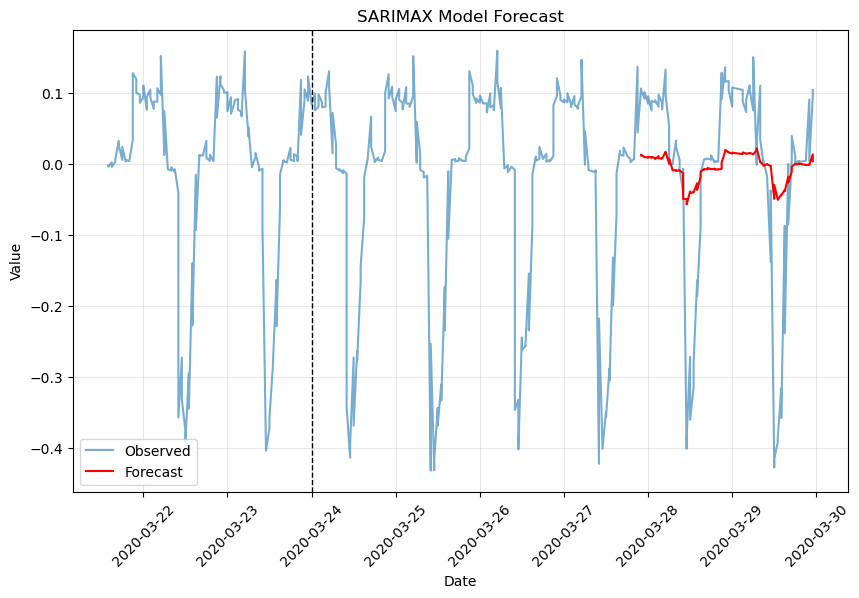

In [ ]:
df2 = df[-400:]
plt.figure(figsize=(10, 6))
plt.plot(df2['datetime'], df2['net_load_norm'], label='Observed',alpha=0.6)
plt.plot(results['datetime'], results['forecast'], label='Forecast', color='red',alpha=1)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMAX Model Forecast')
plt.legend()
plt.xticks(rotation=45) 
plt.grid(alpha=0.3)

plt.axvline(x=pd.to_datetime('2020-3-24 00:00:00'), color='black', linestyle='--',linewidth=1)

plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
norm_mae = mean_absolute_error(results['net_load_norm'], results['forecast'])
print(round(norm_mae,3))

def mean_absolute_arctangent_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(np.arctan((y_true - y_pred) / np.abs(y_true)) / (np.pi / 2)))

maape = mean_absolute_arctangent_percentage_error(results['net_load_norm'], results['forecast'])
print(round(maape,3))


0.111
0.531
